In [140]:
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import pandas as pd
import plotly.express as px
import plotly.io as pio
from pathlib import Path
import string

# Plotly config
pio.templates.default = "ggplot2"
PX_DEFAULT_HEIGHT = 800

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(url="https://twifanworks.shelter.moe/graphql")

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

# TWI (The Wandering Inn) Booru Stats
Below are several graphs displaying the current stats of several features of the Booru such as uploads counts, tag distributions, artist distributions, etc.
__Number go up!__

## Tag Counts

In [134]:
# Get all tag data
first_chars = string.ascii_lowercase + string.digits
tags = None
for c in first_chars:
    # print(f"Getting '{c}' tags")
    tag_query = gql(
        """
        query GetArtistTags {
        """ +
        """
        	tags(limit: 10000, search: "{c}")
        """.format(c=c) +
        """{
              tag,
              uses
            }
        }
        """
    )
    c_tags = await client.execute_async(tag_query)
    # print(pd.DataFrame(c_tags["tags"]))

    tag_data = c_tags["tags"]
    if tags is None:
        tags = pd.DataFrame(tag_data)
    else:
        # tags.merge(pd.DataFrame(tag_data), how="outer")
        tags = pd.concat([tags, pd.DataFrame(tag_data)], ignore_index=True)

tags

figs = []

### Artist Tags

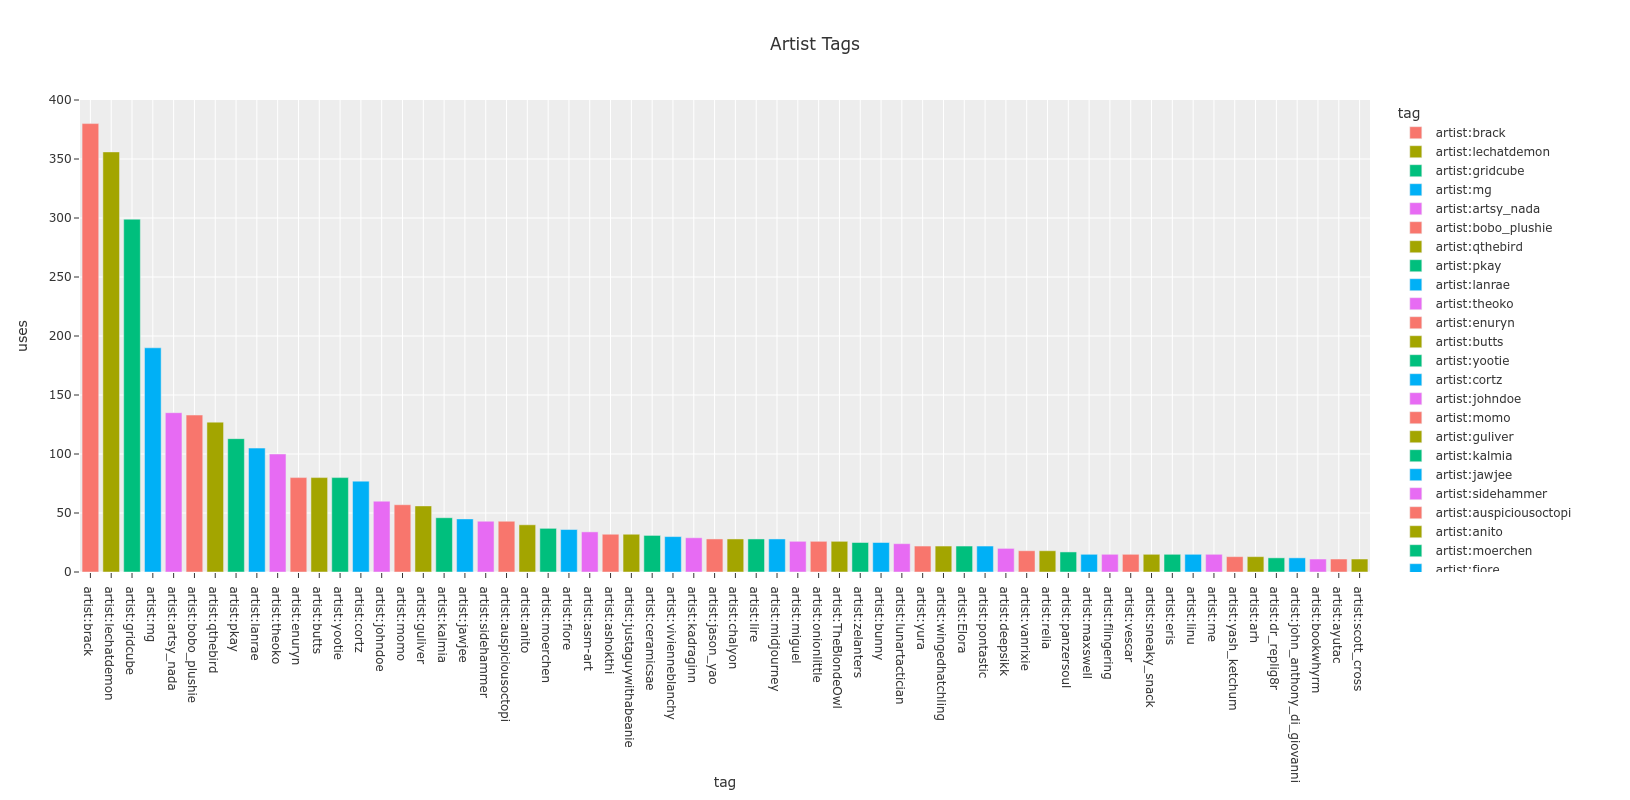

In [141]:
artist_tags  = tags.query("tag.str.startswith('artist:') & uses > 10")
artist_tags.head()

px.bar(
    artist_tags,
    x="tag",
    y="uses",
    color="tag",
    title="Artist Tags",
    height=PX_DEFAULT_HEIGHT,
).show()

### Character Tags

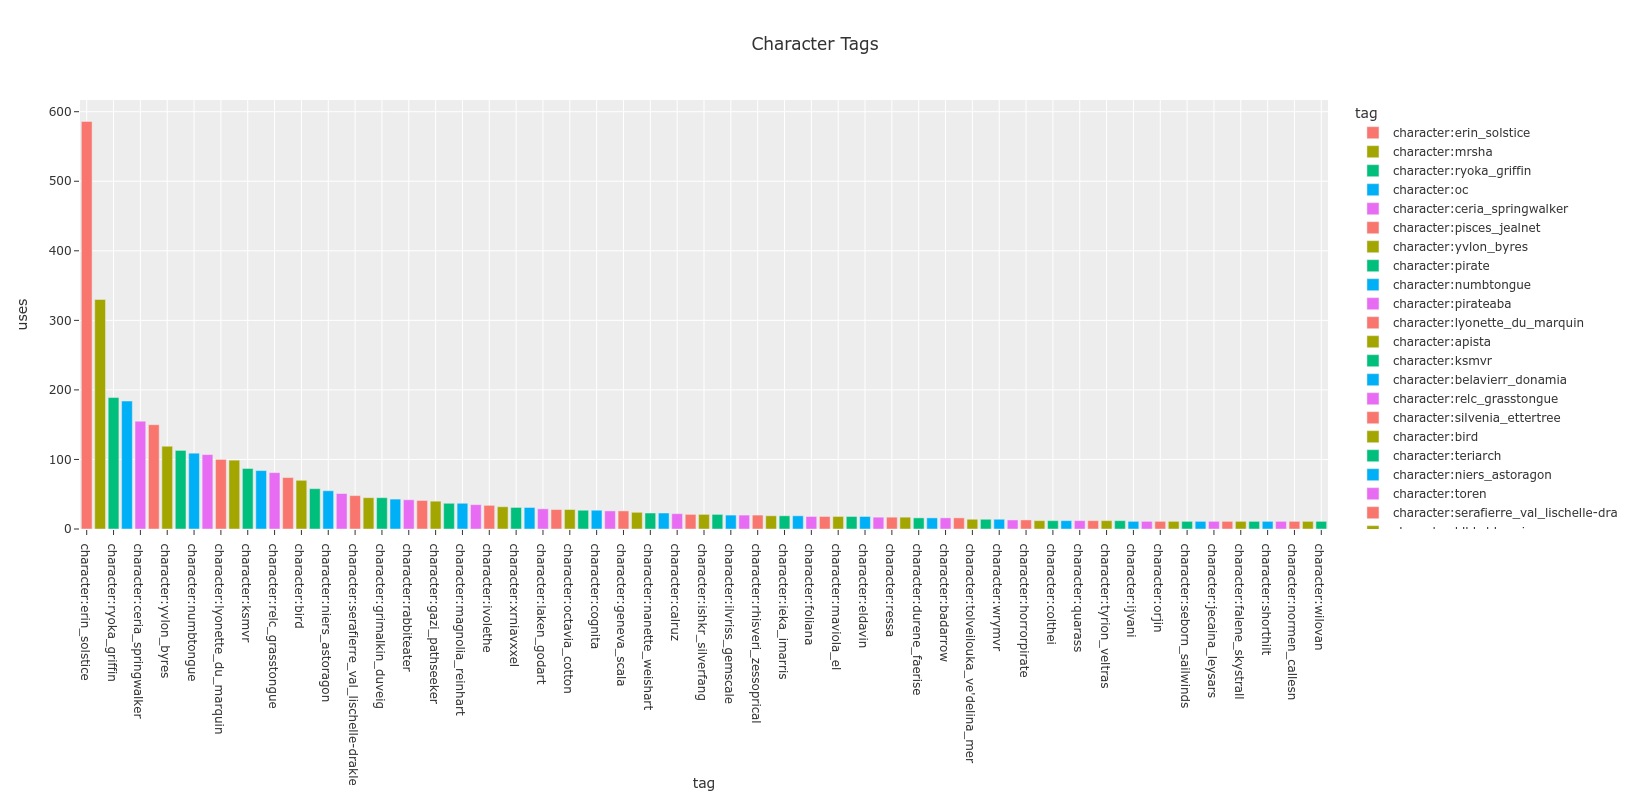

In [142]:
character_tags = tags.query("tag.str.startswith('character:') & uses > 10")
character_tags.head()

px.bar(
    character_tags,
    x="tag",
    y="uses",
    color="tag",
    title="Character Tags",
    height=PX_DEFAULT_HEIGHT,
).show()

## Posts

In [222]:
posts_query = gql(
    """
    query GetPosts {
    	posts(limit: 10000, offset: 0) {
          post_id,
          posted,
          image_link,
          mime,
          ext,
          info,
          locked,
          height,
          width,
          filesize,
          source,
          tags,
        }
    }
    """
)



post_data = await client.execute_async(posts_query)
posts = pd.DataFrame(post_data["posts"])
posts["posted"] = posts["posted"].apply(pd.to_datetime)

In [219]:
# df.columns = ["date", "uploads", "total_uploads"]

sorted_posts = posts.sort_values("posted", ascending=True)
first_post = sorted_posts.iloc[0]
last_post = sorted_posts.iloc[-1]

diff = last_post["posted"].date() - first_post["posted"].date()
diff.days

942

### Uploads Per Day

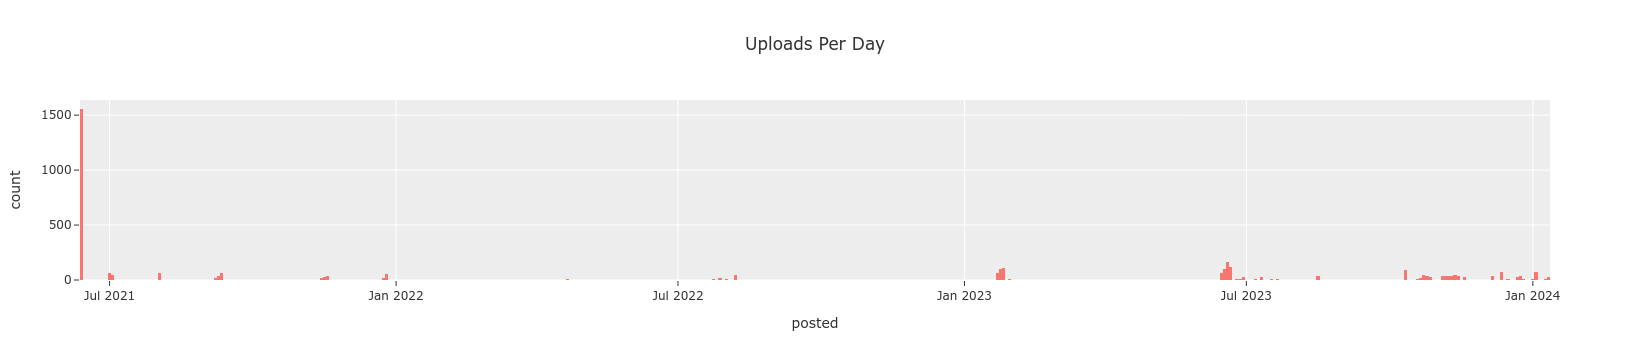

In [221]:
px.histogram(
    posts,
    x="posted",
    title="Uploads Per Day",
    cumulative=False,
    barmode="group",
    nbins=diff.days,
).show()

### Total Cumulative Uploads
Total cumulative uploads since the Booru migration in 2021

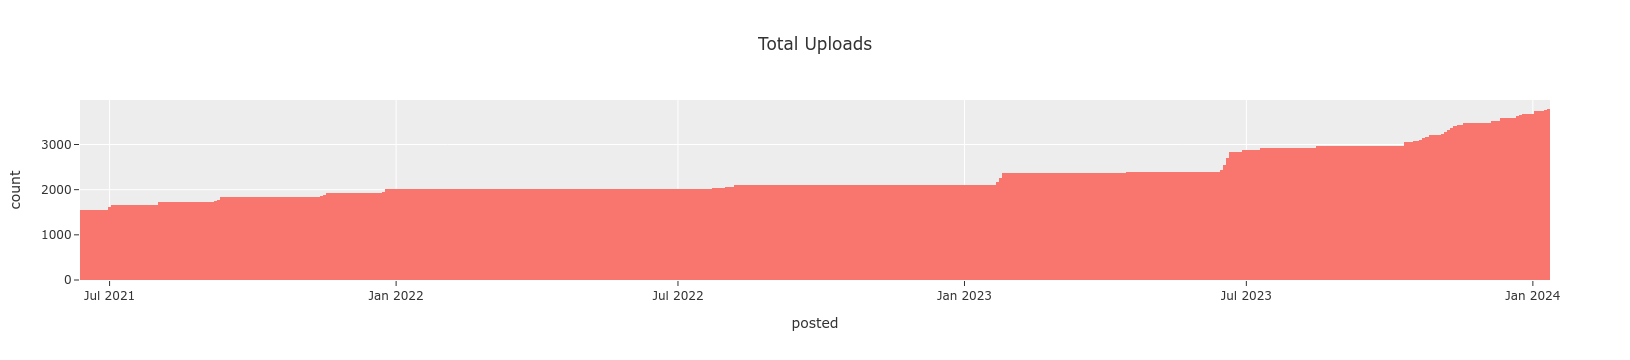

In [220]:
px.histogram(
    posts,
    x="posted",
    title="Total Uploads",
    cumulative=True,
    barmode="group",
    nbins=diff.days,
).show()